### Import libraries

- In the cell_data_analysis folder, data from the cells is extracted. Keep in mind that it can be complicated if they are not clearly visible.
- Here are the videos of your university to analyze: https://www.nanolive.ch/publication-biolab-universidad-de-la-laguna/ and https://cloud.iac.es/index.php/s/df5ZcfiAKFiPdAx
- The videos are in the folder "ata/240319_SW1573_Control_OLL452_OLL519_20uM_extracted_data
- They don't move much, so the object_tracking_from_scratch_source_cede code may suffice (download the code from here as I can't upload it because it's too heavy).
- Here is the code for cell detection: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-03635-x

- With XXX are the irregularities of the data to talk about

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from  datetime import datetime
import time as tt
import pickle
import os
%matplotlib inline

metrics = [1,2,3,4,5,6,7,8,9,10,13,15,16,19,20]

## Preliminary analysis of the data
we observe the structure of the original data (we take the first file as a sample)

In [2]:
file = f'data/original/Cell metrics_{metrics[0]} copy.csv'
df = pd.read_csv(file)
df

,Well,Cycle,Time,Cell Index,Cell area [um^2],Cell area [%],Cell perimeter [um],Cell form factor,Cell extent,Cell compactness,Cell eccentricity,Mean RI,Average dry mass density [pg / um^3],Dry mass [pg],Cell granularity
0,A1,1,00:00:20,1,471.48,0.776572,275.3940,0.078120,0.425646,12.80080,0.735266,1.34773,0.088648,133.747,5.86423
1,A1,1,00:00:20,2,408.56,0.672937,139.5090,0.263790,0.525547,3.79089,0.847883,1.34878,0.093876,122.733,7.12153
2,A1,1,00:00:20,3,737.20,1.214240,354.5060,0.073714,0.398504,13.56600,0.910670,1.34362,0.068090,160.628,9.07188
3,A1,1,00:00:20,4,495.96,0.816893,166.9360,0.223645,0.403220,4.47138,0.925866,1.34592,0.079605,126.339,6.13479
4,A1,1,00:00:20,5,483.96,0.797128,169.2730,0.212248,0.616196,4.71146,0.779687,1.34906,0.095314,147.609,7.78636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40589,B2,400,19:58:42,10,278.92,0.459408,83.8063,0.499041,0.690533,2.00384,0.478492,1.37901,0.245073,218.738,7.51191
40590,B2,400,19:58:42,11,457.08,0.752854,110.9060,0.466975,0.624426,2.14144,0.677771,1.35923,0.146156,213.776,4.54448
40591,B2,400,19:58:42,12,336.36,0.554017,103.1270,0.397437,0.619584,2.51612,0.400319,1.37027,0.201356,216.730,6.42875
40592,B2,400,19:58:42,13,324.28,0.534120,92.8264,0.472919,0.619328,2.11453,0.501096,1.36710,0.185498,192.490,5.45029


Description of the columns

![title](documentos/parametros.png)

Check the size of files:

In [3]:
for metric in metrics:
    # load the file
    file = f'data/original/Cell metrics_{metric} copy.csv'
    df = pd.read_csv(file)
    
    #check if there is NaNs in the data
    # and if there is NaNs print how many
    if df.isnull().values.any():
        print(f'File {metric:.2d} has {df.isnull().sum()} NaNs out of {len(df)}: {df.shape}')
    else:
        print(f'File {metric:02d} has not NaNs. Columns: {df.shape[1]:02d} Rows: {df.shape[0]:,}')

# empty the variable to free memory
df = None

File 01 has not NaNs. Columns: 15 Rows: 40,594
File 02 has not NaNs. Columns: 15 Rows: 68,455
File 03 has not NaNs. Columns: 15 Rows: 18,081
File 04 has not NaNs. Columns: 15 Rows: 56,657
File 05 has not NaNs. Columns: 15 Rows: 72,667
File 06 has not NaNs. Columns: 15 Rows: 77,234
File 07 has not NaNs. Columns: 15 Rows: 60,380
File 08 has not NaNs. Columns: 15 Rows: 136,958
File 09 has not NaNs. Columns: 15 Rows: 136,958
File 10 has not NaNs. Columns: 15 Rows: 42,306
File 13 has not NaNs. Columns: 15 Rows: 54,173
File 15 has not NaNs. Columns: 15 Rows: 26,841
File 16 has not NaNs. Columns: 15 Rows: 60,004
File 19 has not NaNs. Columns: 15 Rows: 95,709
File 20 has not NaNs. Columns: 15 Rows: 98,552


XXX: Sabemos si el archivo 8 y 9 son los mismos?

import the table with the mapping of each compound


- Antes me daba error pero para poder ver las gráficas bien he supuesto que estan mal el 13 y 15 y falta control en la 20
- XXX: Archivo 15 falta el B1, archivo 13 sobra el B2 (se han intercambiado los nombres?)
- XXX: Archivo 20 falta el control en la tabla (Se hizo?)
- XXX: pone ControlSW en metrica 5

In [4]:
df_compounds = pd.read_excel('data/original/Nombre de los productos.xlsx',header=0, names=["Experimento","A1","A2","B1","B2"])
df_compounds

,Experimento,A1,A2,B1,B2
0,1,Control,Taxol,Vimblastina,Colchicina
1,2,Control,Cisplatino,DTA100,NaN
2,3,Control,5-fluouracilo,Nocodazol,Etoposido
3,4,Control,Control,Taxol,Vimblastina
4,5,Control,Tamoxifeno,Rapamycin,cloroquine
5,6,Control,Control,Rapamycin,cloroquine
6,7,Vimblastina,Colchicina,DTA100,Doxorubicina
7,8,Etoposido,DTA100,Colchicina,Taxol
8,9,Control,5-fluouracilo,Vimblastina,Tamoxifeno
9,10,Doxorubicina,DTA100,Control,Tamoxifeno


XXX: 11-13-14 are experinental compounds (no sirven para el análisis)

we see how many compounds there are and how many times they have been analyzed.

In [5]:
# create a list with all the compounds in all the experiments
all_compounds = [compound for row in df_compounds[['A1','A2','B1','B2']].values for compound in row]
# select only one repetition of each compound (remove duplicates)
unique_compounds = list(set(all_compounds))
# remove the NaNs (for the runs with less than 4 compounds)
unique_compounds.remove(np.nan)
# sort the list
unique_compounds.sort()
# print the list with the number of times each compound appears
for compound in unique_compounds:
    print(f"{compound:<15} compound has been tested {all_compounds.count(compound):02d} times in the experiments")

5-fluouracilo   compound has been tested 02 times in the experiments
ABL             compound has been tested 01 times in the experiments
BEL             compound has been tested 01 times in the experiments
Cisplatino      compound has been tested 01 times in the experiments
Colchicina      compound has been tested 05 times in the experiments
Control         compound has been tested 15 times in the experiments
DTA100          compound has been tested 04 times in the experiments
Doxorubicina    compound has been tested 02 times in the experiments
Etoposido       compound has been tested 02 times in the experiments
LSL             compound has been tested 01 times in the experiments
MOA             compound has been tested 01 times in the experiments
Nocodazol       compound has been tested 01 times in the experiments
OLL461          compound has been tested 01 times in the experiments
OLL465          compound has been tested 01 times in the experiments
Rapamycin       compound has been 

Now with the clean data we see that all have the same column names

In [6]:
# Check that all have the same columns

for metric_j in metrics:
    # Load one of the files
    df_metric_j = pd.read_csv(f'data/metrics_{metric_j}.csv')
    # and compare it with the rest
    for metric_i in metrics:
        # load one file
        df_metric_i = pd.read_csv(f'data/metrics_{metric_i}.csv')
        # compute the intersection of the sets of columns of the two files
        columns_difference = (set(df_metric_i.columns)-set(df_metric_j.columns)) | (set(df_metric_j.columns)-set(df_metric_i.columns))
        # if there are columns that are different print them
        if len(columns_difference):
            print(f"Metric {metric_i} has {columns_difference} columns than are differente from Metric {metric_j}")
    df_metric_i = None
    print(f"All okey between {metric_j:02d} and the rest")

# empty the variable to free memory
df_metric_j = None

All okey between 01 and the rest
All okey between 02 and the rest
All okey between 03 and the rest
All okey between 04 and the rest
All okey between 05 and the rest
All okey between 06 and the rest
All okey between 07 and the rest
All okey between 08 and the rest
All okey between 09 and the rest
All okey between 10 and the rest
All okey between 13 and the rest
All okey between 15 and the rest
All okey between 16 and the rest
All okey between 19 and the rest
All okey between 20 and the rest


If we want to rename some columns we can use the following code

In [7]:
# Rename the headers of the df to have the same in all the files

# file = f'data/original/Cell metrics_1 copy.csv'
# df = pd.read_csv(file)
# columns_names =  set(df.columns)

# for i in metrics:
    
#     new_file = f'data/metrics_{i}.csv'
#     old_file = f'data/original/Cell metrics_{i} copy.csv'
#     if os.path.exists(new_file):
#         df_old = pd.read_csv(new_file)
#     else:
#         df_old = pd.read_csv(old_file)

#     old_header = "Cell extent"

#     new_file = f'data/metrics_{i}.csv'    
#     new_header = "Extent"
    
#     if old_header in df_old.columns:
#         df_old.rename(columns={old_header:new_header},inplace=True)
#         df_old.to_csv(new_file,index=False)

In [8]:
# Move the rest of the df
# for i in metrics:
#     new_file = f'data/metrics_{i}.csv'
#     old_file = f'data/original/Cell metrics_{i} copy.csv'
#     if not os.path.exists(new_file):
#         df_old = pd.read_csv(old_file)
#         df_old.to_csv(new_file,index=False)

- XXX: some experiments have 300 cicles and others 400

In [9]:
for metric in metrics:
    # load the file
    file = f'data/metrics_{metric}.csv'
    df = pd.read_csv(file)
    
    print(f'File {file} has {df["Cycle"].max()} cycles {[str(well)+"="+str(len(df[df["Well"]==well]["Cycle"].unique())) for well in df["Well"].unique()]}')


File data/metrics_1.csv has 400 cycles ['A1=400', 'A2=400', 'B1=400', 'B2=400']
File data/metrics_2.csv has 400 cycles ['A1=400', 'A2=400', 'B1=400']
File data/metrics_3.csv has 400 cycles ['A1=400', 'A2=400', 'B1=400', 'B2=400']
File data/metrics_4.csv has 400 cycles ['A1=400', 'A2=400', 'B1=400', 'B2=400']
File data/metrics_5.csv has 400 cycles ['A1=400', 'A2=400', 'B1=400', 'B2=400']
File data/metrics_6.csv has 400 cycles ['A1=400', 'A2=400', 'B1=400', 'B2=400']
File data/metrics_7.csv has 400 cycles ['A1=400', 'A2=400', 'B1=323', 'B2=400']
File data/metrics_8.csv has 400 cycles ['A1=400', 'A2=400', 'B1=400', 'B2=400']
File data/metrics_9.csv has 400 cycles ['A1=400', 'A2=400', 'B1=400', 'B2=400']
File data/metrics_10.csv has 400 cycles ['A1=400', 'A2=400', 'B1=400', 'B2=400']
File data/metrics_13.csv has 400 cycles ['A1=400', 'A2=400', 'B1=400', 'B2=400']
File data/metrics_15.csv has 300 cycles ['A1=300', 'A2=300', 'B2=300']
File data/metrics_16.csv has 400 cycles ['A1=400', 'A2=40

Check the name of each compound in the experiments

In [10]:

for metric in metrics:
    # load the file with the data
    file = f'data/metrics_{metric}.csv'
    df = pd.read_csv(file)
    # load the file with the compounds
    df_metric = df_compounds[['A1','A2','B1','B2']][df_compounds['Experimento']==metric]
    # get the names of the compounds
    names = df_metric.values
    # remove the NaNs
    names = names[~pd.isnull(df_metric)]
    # get the wells of the data
    wells = df["Well"].unique()
    
    if len(wells) != len(names):
        print(f"\nERROR, Well and Names have different lengths, please check the file {file}")
        print("-"*40)
        print(wells, names)
        print(df_metric)
        print("-"*40)

    
    else:
        #check how many compounds are in the file
        print(f'File {file} has {len(wells)} compounds and {len(set(names))} uniques:',[f"{x} = {name}" for x ,name in zip(wells,names)])

File data/metrics_1.csv has 4 compounds and 4 uniques: ['A1 = Control', 'A2 = Taxol', 'B1 = Vimblastina', 'B2 = Colchicina']
File data/metrics_2.csv has 3 compounds and 3 uniques: ['A1 = Control', 'A2 = Cisplatino', 'B1 = DTA100']
File data/metrics_3.csv has 4 compounds and 4 uniques: ['A1 = Control', 'A2 = 5-fluouracilo', 'B1 = Nocodazol', 'B2 = Etoposido']
File data/metrics_4.csv has 4 compounds and 3 uniques: ['A1 = Control', 'A2 = Control', 'B1 = Taxol', 'B2 = Vimblastina']
File data/metrics_5.csv has 4 compounds and 4 uniques: ['A1 = Control', 'A2 = Tamoxifeno', 'B1 = Rapamycin', 'B2 = cloroquine']
File data/metrics_6.csv has 4 compounds and 3 uniques: ['A1 = Control', 'A2 = Control', 'B1 = Rapamycin', 'B2 = cloroquine']
File data/metrics_7.csv has 4 compounds and 4 uniques: ['A1 = Vimblastina', 'A2 = Colchicina', 'B1 = DTA100', 'B2 = Doxorubicina']
File data/metrics_8.csv has 4 compounds and 4 uniques: ['A1 = Etoposido', 'A2 = DTA100', 'B1 = Colchicina', 'B2 = Taxol']
File data/m

see the size of the observations of each experiment

In [11]:
for metric in metrics:
    # load the file
    file = f'data/metrics_{metric}.csv'
    df = pd.read_csv(file)
    # print(df.columns)
    list_string = [f"{well}={df[df['Well']==well]['Object Index'].mean():1.3f}" for well in df["Well"].unique()]
    print(f'File {metric:02d} has {len(df["Cycle"].unique())} cycles and mean cells for well: {list_string}')

File 01 has 400 cycles and mean cells for well: ['A1=23.371', 'A2=9.896', 'B1=13.226', 'B2=8.295']
File 02 has 400 cycles and mean cells for well: ['A1=34.170', 'A2=25.358', 'B1=28.690']
File 03 has 400 cycles and mean cells for well: ['A1=6.850', 'A2=11.264', 'B1=3.001', 'B2=3.676']
File 04 has 400 cycles and mean cells for well: ['A1=23.434', 'A2=31.954', 'B1=6.057', 'B2=13.493']
File 05 has 400 cycles and mean cells for well: ['A1=17.864', 'A2=24.694', 'B1=24.595', 'B2=29.405']
File 06 has 400 cycles and mean cells for well: ['A1=22.547', 'A2=7.918', 'B1=35.234', 'B2=35.567']
File 07 has 400 cycles and mean cells for well: ['A1=17.867', 'A2=17.059', 'B1=18.125', 'B2=28.087']
File 08 has 400 cycles and mean cells for well: ['A1=75.916', 'A2=5.814', 'B1=38.977', 'B2=53.770']
File 09 has 400 cycles and mean cells for well: ['A1=75.916', 'A2=5.814', 'B1=38.977', 'B2=53.770']
File 10 has 400 cycles and mean cells for well: ['A1=21.152', 'A2=11.410', 'B1=11.190', 'B2=11.751']
File 13 has 

Check how many cells are in each picture, to know how much data we could obtain if we would use the evoltion of each cell

In [12]:
# cycle array to store the number of cycles (one for the total and other 2D array for each well)
cycle_ncells = []
cycle_well = []
# array to store the number of cells per cycle (one for the total and other 2D array for each well)
ncells = []
ncells_well = []

# loop over all the metrics
for metric in metrics:
    file = f'data/metrics_{metric}.csv'
    df = pd.read_csv(file)

    # loop over all the wells
    for well in df['Well'].unique():
        cycles_well = []
        cells_well = []

        # loop over all the cycles
        for cycle in df[df['Well']==well]['Cycle'].unique():
            # store the number of cells in the cycle
            ncells.append(df[(df['Well']==well) & (df['Cycle']==cycle)].shape[0])
            cells_well.append(df[(df['Well']==well) & (df['Cycle']==cycle)].shape[0])
            # store the cycle
            cycle_ncells.append(cycle)
            cycles_well.append(cycle)
        # store the cycles and the number of cells arrays for each well in a 2D array
        cycle_well.append(cycles_well)
        ncells_well.append(cells_well)
    

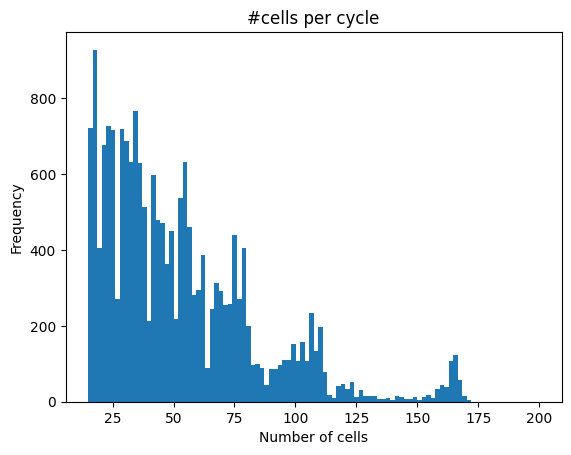

In [13]:
# Creating the histogram of the number of cells per cycle
plt.hist(ncells, bins=100, range=(15, 200))
plt.xlabel("Number of cells")
plt.ylabel("Frequency")
plt.title("#cells per cycle")
plt.show()  

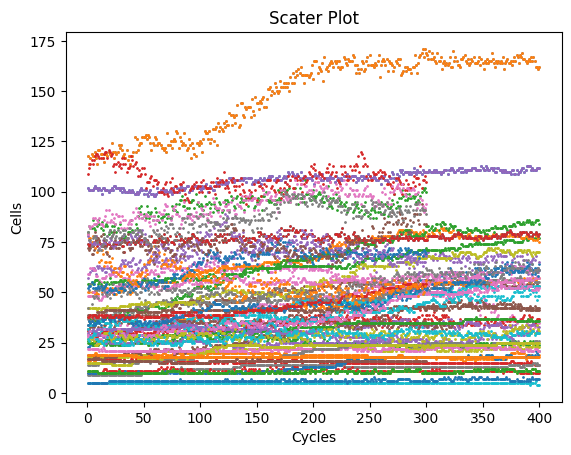

In [14]:
# Creating the scatter plot of the number of cells per cycle in each well
for cycle, cells in zip(cycle_well, ncells_well):
    plt.plot(cycle, cells, '.', markersize=2)

plt.xlabel('Cycles')
plt.ylabel('Cells')
plt.title('Scater Plot')
plt.show()

En el scatter plot vemos como las hay una gran variación en el numbero de celulas.

XXX: Numero de celulas excesivamente alto, es así?
XXX: Gran variabilidad en los experimentos.

Make a plot of the initial vs final number of cells in each experiment. To see if the number of cells increases or decreases

In [15]:
# cycle vs number of cells
initial_cells = []
final_cells = []

for metric in metrics:
    file = f'data/metrics_{metric}.csv'
    df = pd.read_csv(file)
    for well in df['Well'].unique():
        min_cylce = min(df[df['Well']==well]['Cycle'].unique())
        max_cylce = max(df[df['Well']==well]['Cycle'].unique())
        final_cells.append(df[(df['Well']==well) & (df['Cycle']==max_cylce)].shape[0])
        initial_cells.append(df[(df['Well']==well) & (df['Cycle']==min_cylce)].shape[0])

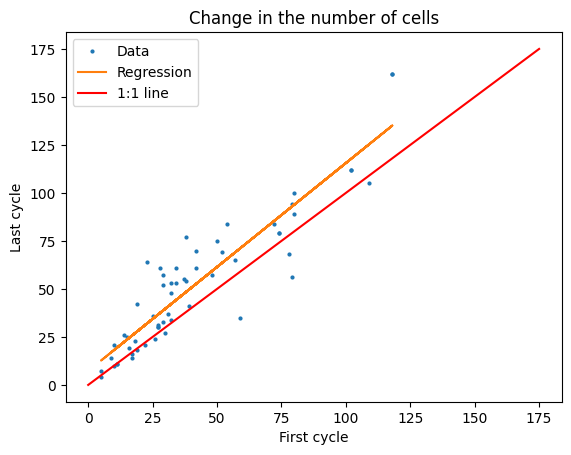

In [16]:
# Creating the scatter plot 
plt.plot(initial_cells, final_cells, '.', markersize=4, label='Data')
# plot a regression line with a shadow error area
plt.plot(initial_cells, np.poly1d(np.polyfit(initial_cells, final_cells, 1))(initial_cells), label='Regression')

# plot a 45 degree red line
plt.plot([0,175],[0,175],'r',label='1:1 line')
plt.xlabel('First cycle')
plt.ylabel('Last cycle')
plt.title('Change in the number of cells')
plt.legend()
plt.show()

- XXX: Tendencia de cada experimento

Time between each frame in the experiment

In [17]:
intervals_time = []

# for each metric
for metric in metrics:
    file = f'data/metrics_{metric}.csv'
    df = pd.read_csv(file)

    # for each well
    for well in df['Well'].unique():

        # get the df of the well
        df_well = df[df['Well']==well]
        # get the time of the cycles (just the first time of each cycle)
        times = []
        for cycle in df_well['Cycle'].unique():
            time = df_well[df_well['Cycle']==cycle]['Time'].values[0]
            times.append(datetime.strptime(time,"%H:%M:%S"))

        list_of_seconds = [(x - datetime.strptime("00:00:00", "%H:%M:%S")).total_seconds() for x in times]
        interval = [x1-x2 for x1,x2 in zip(list_of_seconds[1:],list_of_seconds[:-1]) if x1-x2 != 0]
        intervals_time += interval


Most of the jumps are every 3 minutes (180 seconds)

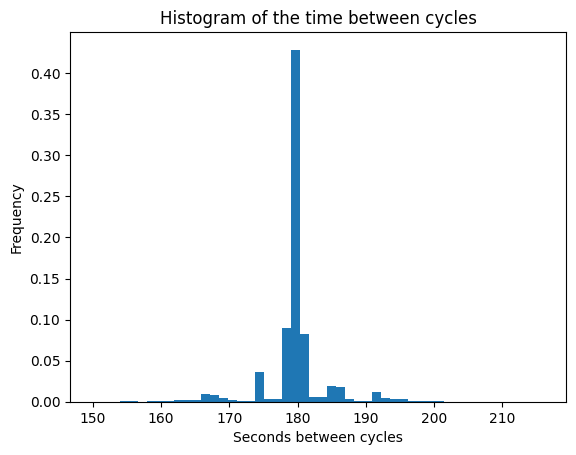

In [18]:
# show the histogram
plt.hist(intervals_time, bins=50, density=True)
plt.title("Histogram of the time between cycles")
plt.ylabel("Frequency")
plt.xlabel("Seconds between cycles")
plt.show()

- XXX: Porque hay distintos tiempos?

### Create a single file with all the data

Import the names of each target

In [19]:
df_compounds = pd.read_excel('data/original/Nombre de los productos.xlsx',header=0, names=["Experimento","A1","A2","B1","B2"])
df_compounds.dropna(subset=['Experimento'], inplace=True)
df_compounds

,Experimento,A1,A2,B1,B2
0,1,Control,Taxol,Vimblastina,Colchicina
1,2,Control,Cisplatino,DTA100,NaN
2,3,Control,5-fluouracilo,Nocodazol,Etoposido
3,4,Control,Control,Taxol,Vimblastina
4,5,Control,Tamoxifeno,Rapamycin,cloroquine
5,6,Control,Control,Rapamycin,cloroquine
6,7,Vimblastina,Colchicina,DTA100,Doxorubicina
7,8,Etoposido,DTA100,Colchicina,Taxol
8,9,Control,5-fluouracilo,Vimblastina,Tamoxifeno
9,10,Doxorubicina,DTA100,Control,Tamoxifeno


we now insert the category of the compound in the data to do the clasiification


<img src="documentos/classification.png" width="400" alt="title">



In [20]:
# so the supergroups are
target_dict = { 
               'Taxol': 'Microtubule',
               'Colchicina': 'Microtubule',
               'Vimblastina': 'Microtubule',
               'DTA100': 'Microtubule',
               'Nocodazol': 'Microtubule',

               'cloroquine': 'Autophagy',
               'Rapamycin': 'Autophagy',
               'Tamoxifeno': 'Autophagy',

                'Cisplatino': 'DNA',
                '5-fluouracilo': 'DNA',
                'Etoposido': 'DNA',
                'Control': 'Control',
                # 'NaN': 'Unknown',
                # 'nan': 'Unknown',
                # np.NaN: 'Unknown'
                }

# set the default target as unknown if the compound is not in the dictionary

def map_target(x):
    if x in target_dict:
        return target_dict[x]
    else:
        return np.NaN
    # else:
        # return 'Unknown'

In [21]:
# Make a classification of the compounds in the df_compounds
df_compounds['A1c'] = df_compounds['A1'].map(map_target)
df_compounds['A2c'] = df_compounds['A2'].map(map_target)
df_compounds['B1c'] = df_compounds['B1'].map(map_target)
df_compounds['B2c'] = df_compounds['B2'].map(map_target)

df_compounds

,Experimento,A1,A2,B1,B2,A1c,A2c,B1c,B2c
0,1,Control,Taxol,Vimblastina,Colchicina,Control,Microtubule,Microtubule,Microtubule
1,2,Control,Cisplatino,DTA100,NaN,Control,DNA,Microtubule,NaN
2,3,Control,5-fluouracilo,Nocodazol,Etoposido,Control,DNA,Microtubule,DNA
3,4,Control,Control,Taxol,Vimblastina,Control,Control,Microtubule,Microtubule
4,5,Control,Tamoxifeno,Rapamycin,cloroquine,Control,Autophagy,Autophagy,Autophagy
5,6,Control,Control,Rapamycin,cloroquine,Control,Control,Autophagy,Autophagy
6,7,Vimblastina,Colchicina,DTA100,Doxorubicina,Microtubule,Microtubule,Microtubule,NaN
7,8,Etoposido,DTA100,Colchicina,Taxol,DNA,Microtubule,Microtubule,Microtubule
8,9,Control,5-fluouracilo,Vimblastina,Tamoxifeno,Control,DNA,Microtubule,Autophagy
9,10,Doxorubicina,DTA100,Control,Tamoxifeno,NaN,Microtubule,Control,Autophagy


In [22]:
# count the number of times we have each target

a1 = df_compounds['A1c'].value_counts() 
a2 = df_compounds['A2c'].value_counts()
b1 = df_compounds['B1c'].value_counts()
b2 = df_compounds['B2c'].value_counts()

# sum all the counters but keep in mind in some of them there are some missing classes
total = a1.add(a2, fill_value=0).add(b1, fill_value=0).add(b2, fill_value=0)
print(total)
# print also the sum of all the categories
print('total count', total.sum())

Autophagy       7.0
Control        15.0
DNA             5.0
Microtubule    21.0
dtype: float64
total count 48.0


- XXX: Clases desbalanceadas

In [23]:
list_df = []
for metric in metrics:
    df = pd.read_csv(f'data/metrics_{metric}.csv')
    df['Metric'] = metric
    df['Wellc'] = df['Well'].map(lambda x: x+'c')
    dict_well = df_compounds[df_compounds['Experimento']==metric].to_dict('records')[0]
    df['Compound'] = df['Well'].map(dict_well)
    df['Target'] = df['Wellc'].map(dict_well)
    list_df.append(df)

In [24]:
df_all = pd.concat(list_df,axis=0)
print(df_all.shape)
df_all

(1045569, 19)


,Well,Cycle,Time,Object Index,Area [um^2],Area [%],Perimeter [um],Form factor,Extent,Compactness,Eccentricity,Characteristic RI,Characteristic dry mass density [pg / um^3],Dry mass [pg],Granularity,Metric,Wellc,Compound,Target
0,A1,1,00:00:20,1,471.48,0.776572,275.3940,0.078120,0.425646,12.80080,0.735266,1.34773,0.088648,133.7470,5.86423,1,A1c,Control,Control
1,A1,1,00:00:20,2,408.56,0.672937,139.5090,0.263790,0.525547,3.79089,0.847883,1.34878,0.093876,122.7330,7.12153,1,A1c,Control,Control
2,A1,1,00:00:20,3,737.20,1.214240,354.5060,0.073714,0.398504,13.56600,0.910670,1.34362,0.068090,160.6280,9.07188,1,A1c,Control,Control
3,A1,1,00:00:20,4,495.96,0.816893,166.9360,0.223645,0.403220,4.47138,0.925866,1.34592,0.079605,126.3390,6.13479,1,A1c,Control,Control
4,A1,1,00:00:20,5,483.96,0.797128,169.2730,0.212248,0.616196,4.71146,0.779687,1.34906,0.095314,147.6090,7.78636,1,A1c,Control,Control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98547,B2,300,15:05:29,85,233.32,0.384300,93.0276,0.338796,0.493611,2.95163,0.859475,1.34889,0.094442,70.5127,7.83123,20,B2c,BEL,NaN
98548,B2,300,15:05:29,86,216.52,0.356629,64.0441,0.663361,0.665478,1.50747,0.639039,1.35986,0.149281,103.4310,7.49048,20,B2c,BEL,NaN
98549,B2,300,15:05:29,87,177.48,0.292326,72.0144,0.430051,0.584585,2.32530,0.910359,1.36513,0.175652,99.7590,4.96674,20,B2c,BEL,NaN
98550,B2,300,15:05:29,88,262.64,0.432593,87.9281,0.426889,0.667276,2.34253,0.737718,1.34972,0.098584,82.8548,8.61766,20,B2c,BEL,NaN


In [25]:
maping_target = {target: i for i,target in enumerate(df_all['Target'].unique())}
df_all['Target'] = df_all['Target'].map(maping_target)
maping_target

{'Control': 0, 'Microtubule': 1, 'DNA': 2, 'Autophagy': 3, nan: 4}

In [26]:
df_all

,Well,Cycle,Time,Object Index,Area [um^2],Area [%],Perimeter [um],Form factor,Extent,Compactness,Eccentricity,Characteristic RI,Characteristic dry mass density [pg / um^3],Dry mass [pg],Granularity,Metric,Wellc,Compound,Target
0,A1,1,00:00:20,1,471.48,0.776572,275.3940,0.078120,0.425646,12.80080,0.735266,1.34773,0.088648,133.7470,5.86423,1,A1c,Control,0
1,A1,1,00:00:20,2,408.56,0.672937,139.5090,0.263790,0.525547,3.79089,0.847883,1.34878,0.093876,122.7330,7.12153,1,A1c,Control,0
2,A1,1,00:00:20,3,737.20,1.214240,354.5060,0.073714,0.398504,13.56600,0.910670,1.34362,0.068090,160.6280,9.07188,1,A1c,Control,0
3,A1,1,00:00:20,4,495.96,0.816893,166.9360,0.223645,0.403220,4.47138,0.925866,1.34592,0.079605,126.3390,6.13479,1,A1c,Control,0
4,A1,1,00:00:20,5,483.96,0.797128,169.2730,0.212248,0.616196,4.71146,0.779687,1.34906,0.095314,147.6090,7.78636,1,A1c,Control,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98547,B2,300,15:05:29,85,233.32,0.384300,93.0276,0.338796,0.493611,2.95163,0.859475,1.34889,0.094442,70.5127,7.83123,20,B2c,BEL,4
98548,B2,300,15:05:29,86,216.52,0.356629,64.0441,0.663361,0.665478,1.50747,0.639039,1.35986,0.149281,103.4310,7.49048,20,B2c,BEL,4
98549,B2,300,15:05:29,87,177.48,0.292326,72.0144,0.430051,0.584585,2.32530,0.910359,1.36513,0.175652,99.7590,4.96674,20,B2c,BEL,4
98550,B2,300,15:05:29,88,262.64,0.432593,87.9281,0.426889,0.667276,2.34253,0.737718,1.34972,0.098584,82.8548,8.61766,20,B2c,BEL,4


Save the df in a single file

In [27]:
path = 'data/all_metrics.csv'
df_all.to_csv(path)

Save the dataset for the classification FCNN

In [28]:
columns_names =  set(df.columns)
# remove the cycle, time, well and object index
columns_names.remove("Well")
# columns_names.remove("Time")
columns_names.remove("Cycle")
columns_names.remove("Object Index")
columns_names.remove("Metric")
columns_names.remove("Wellc")
columns_names.remove("Compound")
columns_names.remove("Target")

In [29]:
list_column_names = list(columns_names)
print(f"Number of columns: {len(list_column_names)}")
list_column_names.sort()
list_column_names

Number of columns: 12


['Area [%]',
 'Area [um^2]',
 'Characteristic RI',
 'Characteristic dry mass density [pg / um^3]',
 'Compactness',
 'Dry mass [pg]',
 'Eccentricity',
 'Extent',
 'Form factor',
 'Granularity',
 'Perimeter [um]',
 'Time']

In [30]:
dataset = {}

x = []
y = []


# loop over all the metrics
for experiment in df_all["Metric"].unique():
    mask_experiment = df_all["Metric"]==experiment

    # loop over all the wells
    for well in df_all[mask_experiment]["Well"].unique():
        mask_well = (df_all["Well"]==well) & (df_all["Metric"]==experiment)
        df_well = df_all[mask_well]

        if df_well["Target"].values[0] == 4:
            continue

        # new dataframe to make the downsampling
        df_downsampled = pd.DataFrame()

        # for each column name make a mean over all the cells in the cycle
        x_sample = np.empty((len(list_column_names) , df_well["Cycle"].unique().shape[0]))
        deltatime_sample = []
        for i,column in enumerate(list_column_names):
            for j,cycle in enumerate(df_well["Cycle"].unique()):
                if column == "Time":
                    # convert the time to seconds
                    deltatime_sample.append(datetime.strptime(df_well[df_well["Cycle"]==cycle][column].values[0], "%H:%M:%S") - datetime.strptime("00:00:00", "%H:%M:%S"))
                    x_sample[i][j] = deltatime_sample[-1].total_seconds()
                else:
                    x_sample[i][j] = df_well[df_well["Cycle"]==cycle][column].mean()
            
            df_downsampled[column] = x_sample[i]
        
        print("Adding time to the dataframe")
        df_downsampled['Time'] = deltatime_sample
        # compute the total time of the experiment
        total_time = deltatime_sample[-1]
        print(f"Total time of the experiment: {total_time}")
        # downsample the data to be a total of 200 points
        actual_size = df_downsampled.shape[0]
        print(f"Actual size of the dataframe: {actual_size}")
        print(f"Downsampling to 200 points")
        # downsample the data to be a total of 200 points
        # for that we need to resample the interval off:
        mean_interval_time = total_time/actual_size
        print(f"Mean time point: {mean_interval_time}")
        new_interval = total_time/(200+2)
        print(f"New interval: {new_interval}")
        df_down = df_downsampled.set_index('Time').resample(new_interval).mean().reset_index()
        # trim the df to 200
        df_down = df_down.iloc[:200]
        print(f"New size of the dataframe: {df_down.shape[0]}")
        print("Converting the time to seconds and normalizing to 24*60*60")
        df_down['Time'] = df_down['Time'].map(lambda x: x.total_seconds())/(24*60*60)
        # pass the df_down to an array of floats
        x_sample = df_down[list_column_names].values.T
        # checking that all the columns are np.array and not array of object
        for i in range(x_sample.shape[0]):
            if type(x_sample[0][i]) != np.float64:
                print(f"Column {list_column_names[i]} is not a np.float64")
                print(f"Type: {type(x_sample[0][i])}")
                print(f"Value: {x_sample[0][i]}")
        print('-'*50)

        x.append(x_sample)
        y.append(df_well["Target"].values[0])

dataset['x'] = np.array(x)
dataset['y'] = np.array(y)
            

Adding time to the dataframe
Total time of the experiment: 19:57:24
Actual size of the dataframe: 400
Downsampling to 200 points
Mean time point: 0:02:59.610000
New interval: 0:05:55.663366
New size of the dataframe: 200
Converting the time to seconds and normalizing to 24*60*60
--------------------------------------------------
Adding time to the dataframe
Total time of the experiment: 19:58:03
Actual size of the dataframe: 400
Downsampling to 200 points
Mean time point: 0:02:59.707500
New interval: 0:05:55.856436
New size of the dataframe: 200
Converting the time to seconds and normalizing to 24*60*60
--------------------------------------------------
Adding time to the dataframe
Total time of the experiment: 19:59:23
Actual size of the dataframe: 400
Downsampling to 200 points
Mean time point: 0:02:59.907500
New interval: 0:05:56.252475
New size of the dataframe: 200
Converting the time to seconds and normalizing to 24*60*60
--------------------------------------------------
Adding 

In [31]:
# save the dataset in a pkl
path = 'data/dataset.pkl'
with open(path, 'wb') as f:
    pickle.dump(dataset, f)